In [40]:
import warnings
warnings.filterwarnings("ignore")
import snowflake.connector as sf
import numpy as np
import pandas as pd
import time
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid', {'legend.frameon':True})
import re
import plotly
import plotly.graph_objects as go
import plotly.offline as pyo
import plotly.express as px
from plotly.subplots import make_subplots
from typing import List, Dict, Any
import json
import calendar

from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier


from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, recall_score, precision_score, accuracy_score, confusion_matrix, \
classification_report, roc_auc_score, roc_curve, precision_recall_curve



import lightgbm as lgb
pd.set_option('display.max_columns', None)
%matplotlib inline

- build a class to easily manage classifiers

In [32]:
class ClassFit:
    def __init__(self, clf, params = None):
        '''
        If parameters are given, initialize the model with parameters,
        otherwise use the default settings
        '''
        if params:
            self.clf = clf(**params)
        else:
            self.clf = clf()
            
    def train(self, X_train, y_train):
        '''
        train the classifier
        '''
        self.clf.fit(X_train, y_train)
        
    def predict(self, X):
        '''
        make predictions
        '''
        return self.clf.predict(X)
    
    def grid_search(self, parameters, Kfold):
        '''
        Initialize grid search object with given model parameters
        '''
        self.grid = GridSearchCV(estimator = self.clf, param_grid = parameters, cv = Kfold)
        
    def grid_fit(self, X, y):
        '''
        fit the model with grid search
        '''
        self.grid.fit(X,y)

In [2]:
df = pd.read_csv("df_cus_overview_fe.csv")
df.head()

CustomerEmail1  Recency  Recency_cluster  Frequency  \
0  01carolinaflores@gmail.com        4                1          3   
1        01snichols@gmail.com       66                1          3   
2           02pyt18@gmail.com       15                1          7   
3         0523aaron@gmail.com       32                1          3   
4          07.mv.07@gmail.com      320                0          3   

   Frequency_cluster  Revenue  Revenue_cluster  Score  churn  member  Promo  \
0                  0   345.03                0      1      1       1      2   
1                  0   545.30                0      1      1       1     10   
2                  0   340.78                0      1      0       1     11   
3                  0   440.51                0      1      1       1      8   
4                  0   660.64                0      0      1       0     34   

   NumOfClass  ReturnFreq  ReturnAmt  TimeSpan  
0           5           0          0       309  
1          16           0          0       522  
2           8           2       -159        69  
3           4           0          0       217  
4          10           0          0        97

In [3]:
df_ml = df.drop('CustomerEmail1', axis = 1)

### Traditional MLs

- Normalize data

In [4]:
# split X,y dataset
X = df_ml.drop('churn', axis=1)
y = df_ml['churn']

In [5]:
# normalize the data
sd_scaler = StandardScaler()
sd_scaler.fit(X)
norm_X = sd_scaler.transform(X)

In [6]:
# split the data
X_train_norm, X_test_norm, y_train, y_test = train_test_split(norm_X, y, test_size = 0.25)

In [7]:
# inistialize the model
lr = LogisticRegression()
knn = KNeighborsClassifier()
svc = SVC()
dt = DecisionTreeClassifier()
rf = RandomForestClassifier()

In [8]:
# check models validation scores

models = [('Logistic Regression', lr),
          ('KNN', knn),
          ('SVC', svc),
          ('Decision Tree', dt),
          ('Random Forest',rf)]



val_scores = []
for i in range(len(models)):
    score = cross_val_score(models[i][1], norm_X, y, cv = 5)
    val_scores.append({f'{models[i][0]} cross_val scores' : np.mean(score)})
val_scores

[{'Logistic Regression cross_val scores': 0.7035186943295451},
 {'KNN cross_val scores': 0.6645632710109021},
 {'SVC cross_val scores': 0.7076815940360918},
 {'Decision Tree cross_val scores': 0.615704542334744},
 {'Random Forest cross_val scores': 0.6965073968089712}]

In [9]:
# get classification report
for i in range(len(models)):
    model = models[i][1]
    cursor = model.fit(X_train_norm, y_train)
    y_pred = model.predict(X_test_norm)
    print(models[i][0],'\n',classification_report(y_test, y_pred),'\n')

Logistic Regression 
               precision    recall  f1-score   support

           0       0.68      0.60      0.64      2485
           1       0.72      0.78      0.75      3221

    accuracy                           0.70      5706
   macro avg       0.70      0.69      0.69      5706
weighted avg       0.70      0.70      0.70      5706
 

KNN 
               precision    recall  f1-score   support

           0       0.62      0.61      0.61      2485
           1       0.70      0.72      0.71      3221

    accuracy                           0.67      5706
   macro avg       0.66      0.66      0.66      5706
weighted avg       0.67      0.67      0.67      5706
 

SVC 
               precision    recall  f1-score   support

           0       0.69      0.59      0.64      2485
           1       0.71      0.80      0.75      3221

    accuracy                           0.71      5706
   macro avg       0.70      0.69      0.69      5706
weighted avg       0.70      0.71   

#### Reduce Multi-colinearity

- HeatMap

In [10]:
def heatmap(data: pd.core.frame.DataFrame):
    plt.figure(figsize=(16,6))
    np.triu(np.ones_like(data.corr()))
    mask = np.triu(np.ones_like(data.corr(), dtype = np.bool))
    heatmap = sns.heatmap(data.corr(),
                          mask = mask,
                          vmin = 1,
                          vmax = 1,
                          annot = True,
#                           cmap = 'BrBG'
                         )
    

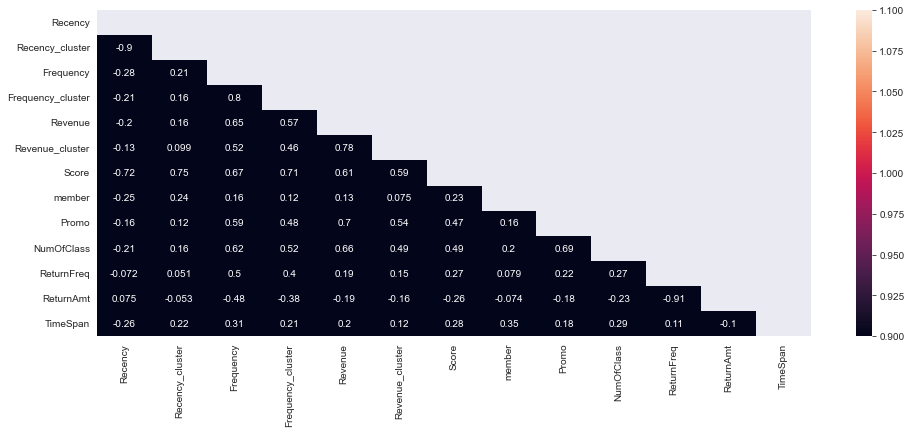

In [11]:
corr_df = df.drop(['churn'], axis=1)
heatmap(corr_df)

- VIF

In [12]:
def vif(data):
    vif_data = pd.DataFrame()
    vif_data['feature'] = data.columns
    
    vif_data['VIF'] = [variance_inflation_factor(data.values, i) for i in range(len(data.columns))]
    return vif_data

In [13]:
df_v = df.drop(['CustomerEmail1', 'churn'], axis = 1)
vif(df_v)

feature       VIF
0             Recency  1.856891
1     Recency_cluster       inf
2           Frequency  8.620754
3   Frequency_cluster       inf
4             Revenue  9.238314
5     Revenue_cluster       inf
6               Score       inf
7              member  2.289756
8               Promo  3.634069
9          NumOfClass  8.691222
10         ReturnFreq  7.142263
11          ReturnAmt  6.826478
12           TimeSpan  3.271381

According to Need to drop 4 features shows infinit correlations that maylead to multicollinearity problem:
- Recency_cluster
- Frequency_cluster
- Revenue_cluster
- Score



### Drop bad features to train model again

In [14]:
df = df.drop(['CustomerEmail1','Recency_cluster','Frequency_cluster','Revenue_cluster','Score'], axis=1)
# df = df.drop(, axis = 1)

In [15]:
vif(df.drop('churn', axis=1))

feature       VIF
0     Recency  1.436561
1   Frequency  5.557982
2     Revenue  5.762988
3      member  2.135429
4       Promo  3.409946
5  NumOfClass  7.305305
6  ReturnFreq  7.122687
7   ReturnAmt  6.817657
8    TimeSpan  3.026676

### Rerun the model on selected features, and use Classification report and AOC to evaluate the model performance

In [16]:
# re-normalize the data after VIF
sd_scaler = StandardScaler()
sd_scaler.fit(df.drop('churn', axis = 1))
norm_X_ =sd_scaler.transform(df.drop('churn', axis = 1)) 

In [17]:
# re-split the data
X_train, X_test, y_train, y_test = train_test_split(norm_X_, y, test_size=0.2)

In [18]:
for i in range(len(models)):
    model = models[i][1]
    cursor = model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print(models[i][0],'\n',classification_report(y_test, y_pred),'\n')

Logistic Regression 
               precision    recall  f1-score   support

           0       0.69      0.58      0.63      2000
           1       0.71      0.80      0.75      2565

    accuracy                           0.70      4565
   macro avg       0.70      0.69      0.69      4565
weighted avg       0.70      0.70      0.70      4565
 

KNN 
               precision    recall  f1-score   support

           0       0.61      0.59      0.60      2000
           1       0.69      0.71      0.70      2565

    accuracy                           0.66      4565
   macro avg       0.65      0.65      0.65      4565
weighted avg       0.66      0.66      0.66      4565
 

SVC 
               precision    recall  f1-score   support

           0       0.69      0.57      0.63      2000
           1       0.71      0.80      0.75      2565

    accuracy                           0.70      4565
   macro avg       0.70      0.69      0.69      4565
weighted avg       0.70      0.70   

#### Takeaways from model retrains after VIF:
- It increased 2% accuracy for logistic regressions from 78% to 80%

In [19]:
'''
get auc scores from cross-validation training results
'''
auc_scores = []
for i in range(len(models)):
    # get each model
    model = models[i][1]
    
    # get cross-validation predictions from each model
    y_pred = cross_val_predict(model, X_train, y_train, cv = 5)
    
    #get auc scores
    auc_score = roc_auc_score(y_train, y_pred)
    auc_scores.append({f'{models[i][0]} auc_scores' : auc_score})
    
auc_scores

[{'Logistic Regression auc_scores': 0.6935244854508126},
 {'KNN auc_scores': 0.6601213111277898},
 {'SVC auc_scores': 0.696793821050928},
 {'Decision Tree auc_scores': 0.6180609563956605},
 {'Random Forest auc_scores': 0.688521130131971}]

- Visualize the AUC score

In [20]:
log_pred = cross_val_predict(LogisticRegression(), X_train, y_train, cv=5, method = 'decision_function')
knn_pred = cross_val_predict(KNeighborsClassifier(), X_train, y_train, cv=5)
svc_pred = cross_val_predict(SVC(), X_train, y_train, cv=5)
dt_pred = cross_val_predict(DecisionTreeClassifier(), X_train, y_train, cv=5)
rf_pred = cross_val_predict(RandomForestClassifier(), X_train, y_train, cv=5)

In [21]:
# logistic regression
log_fpr, log_tpr, log_thre = roc_curve(y_train, log_pred)

# knn
knn_fpr, knn_tpr, knn_thre = roc_curve(y_train, knn_pred)

# svm
svc_fpr, svc_tpr, svc_thre = roc_curve(y_train, svc_pred)

# decision tree
dt_fpr, dt_tpr, dt_thre = roc_curve(y_train, dt_pred)

# random forest
rf_fpr, rf_tpr, rf_thre = roc_curve(y_train, rf_pred)

In [22]:
roc_auc_score(y_train, log_pred)

0.77029389563792

In [23]:
# plot out the auc roc curve
def plot_multi_auc_roc(log_fpr, log_tpr, 
                       knn_fpr, knn_tpr, 
                       svc_fpr, svc_tpr,
                       dt_fpr, dt_tpr,
                       rf_fpr, rf_tpr):
    plt.figure(figsize=(16,8))
    plt.title('ROC Curve', fontsize=18)
    plt.plot(log_fpr, log_tpr, label = 'Logistic Regression: {:.4f}'.format(roc_auc_score(y_train, log_pred)))
    plt.plot(knn_fpr, knn_tpr, label = 'KNN: {:.4f}'.format(roc_auc_score(y_train, knn_pred)))
    plt.plot(svc_fpr, svc_tpr, label = 'SVM: {:.4f}'.format(roc_auc_score(y_train, svc_pred)))
    plt.plot(dt_fpr, dt_tpr, label = 'Decision Tree: {:.4f}'.format(roc_auc_score(y_train, dt_pred)))
    plt.plot(rf_fpr, rf_tpr, label = 'Random Forest: {:.4f}'.format(roc_auc_score(y_train, rf_pred)))
    
    plt.plot([0,1], [0,1], 'k--')
    plt.axis([-0.01, 1, 0, 1])
    plt.xlabel('False Positive Rate', fontsize = 16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.legend()
    

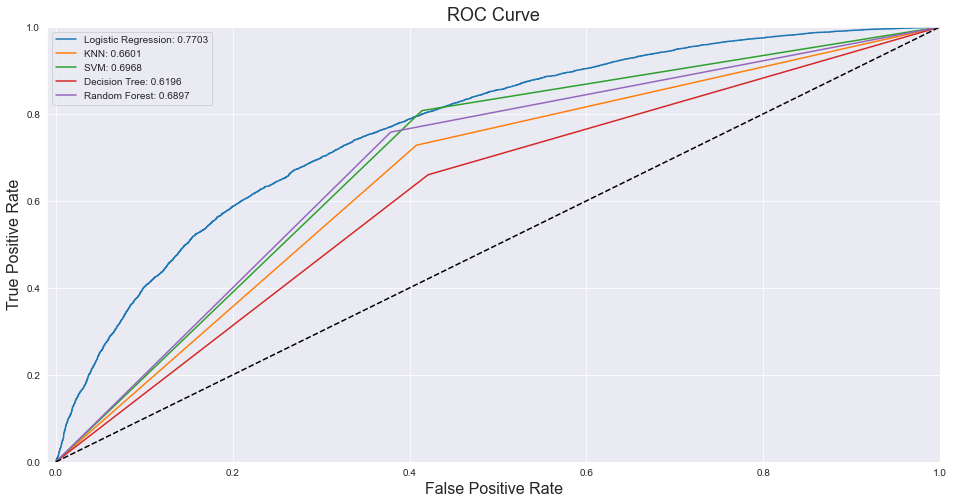

In [24]:
plot_multi_auc_roc(log_fpr, log_tpr, knn_fpr, knn_tpr,  svc_fpr, svc_tpr, dt_fpr, dt_tpr, rf_fpr, rf_tpr)

#### Takeways from AUC:
- Logistic Regression has **best ability** to descriminate between classes
- SVM is 2nd best classifier

visualzie logistic regression's AUC score

In [25]:
def logistic_roc_curving(log_fpr, log_tpr):
    
    '''
    Function to plot out roc curve
    '''
    plt.figure(figsize=(12,8))
    plt.title('Logistic Regression ROC Curve', fontsize=16)
    plt.plot(log_fpr, log_tpr, 'b-', linewidth =2 )
    plt.plot([0,1],[0,1], 'r--')
    plt.xlabel('False Positve Rate', fontsize=16)
    plt.ylabel('True Positive Rate', fontsize=16)
    plt.axis([-0.01,1,0,1])

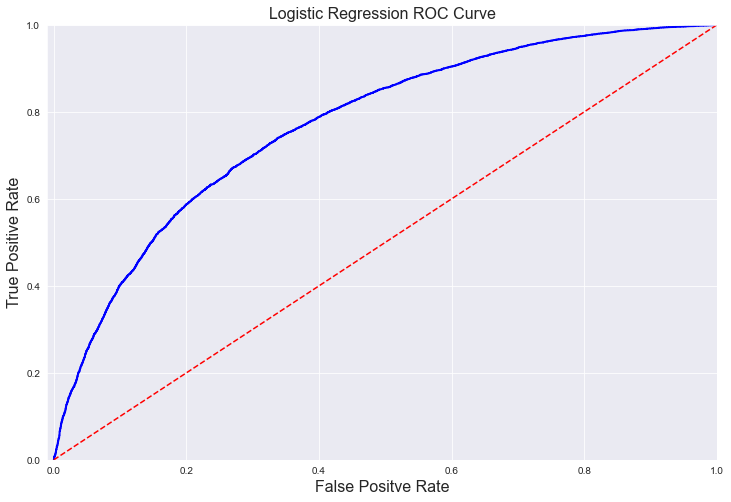

In [26]:
logistic_roc_curving(log_fpr, log_tpr)
plt.show()

- Use test data to test logistic regression

In [27]:
# get predictions on test set

'''
fit the predictors
'''

lr = LogisticRegression()
lr.fit(X_train, y_train)

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

svc = SVC()
svc.fit(X_train, y_train)

dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)

rf = RandomForestClassifier()
rf.fit(X_train, y_train)

'''
get prediction results for test data
'''

y_pred_log = lr.predict(X_test) # logistic regression
y_pred_knn = knn.predict(X_test) # knn
y_pred_svc = svc.predict(X_test) # svm
y_pred_dt = dt.predict(X_test) # decision tree
y_pred_rf = rf.predict(X_test) # random forest

### Try gradient boost framework

**Try Adaboost with both logistic regression and SVM**

In [41]:
# ada = ClassFit(clf = AdaBoostClassifier)

# ada.grid_search(parameters = {
#     'base_estimator': [LogisticRegression('penalty' == 'l1'),
#                        LogisticRegression('penalty' == 'l2'),
#                        LogisticRegression('penalty' == 'elasticnet')],
#                         'algorithm': ['SAMME', 'SAMME.R']}, Kfold = 5)

#### Confusion Matrix visualizations

[Text(0.5, 0, ''), Text(1.5, 0, '')]

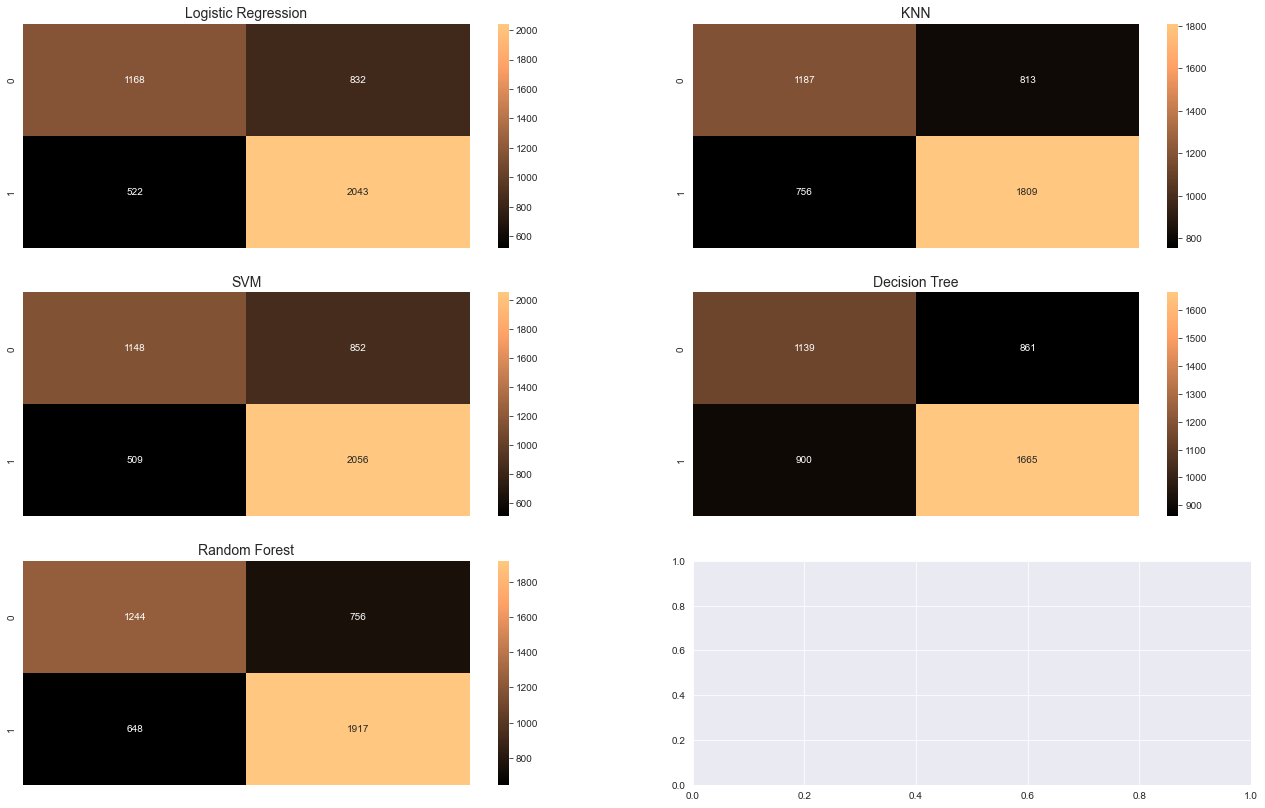

In [28]:
# create confusion matrix
log_cf_matrix = confusion_matrix(y_test, y_pred_log)
knn_cf_matrix = confusion_matrix(y_test, y_pred_knn)
svc_cf_matrix = confusion_matrix(y_test, y_pred_svc)
dt_cf_matrix = confusion_matrix(y_test, y_pred_dt)
rf_cf_matrix = confusion_matrix(y_test, y_pred_rf)

# visualize the confusion matrix
models_cf_matrix = [('Logistic Regression', log_cf_matrix),
                   ('KNN', knn_cf_matrix),
                   ('SVM', svc_cf_matrix),
                   ('Decision Tree', dt_cf_matrix),
                   ('Random Forest', rf_cf_matrix)]



fig, ax = plt.subplots(3,2,figsize=(22,14))

# logistic regression
sns.heatmap(models_cf_matrix[0][1], ax = ax[0][0], annot = True, cmap = plt.cm.copper, fmt = 'g')
ax[0,0].set_title(models_cf_matrix[0][0], fontsize=14)
ax[0,0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0,0].set_xticklabels(['', ''], fontsize=14, rotation=360)

# KNN
sns.heatmap(models_cf_matrix[1][1], ax = ax[0][1], annot = True, cmap = plt.cm.copper, fmt = 'g')
ax[0,1].set_title(models_cf_matrix[1][0], fontsize=14)
ax[0,1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[0,1].set_xticklabels(['', ''], fontsize=14, rotation=360)


# SVM
sns.heatmap(models_cf_matrix[2][1], ax = ax[1][0], annot = True, cmap = plt.cm.copper, fmt = 'g')
ax[1,0].set_title(models_cf_matrix[2][0], fontsize=14)
ax[1,0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1,0].set_xticklabels(['', ''], fontsize=14, rotation=360)


# Decision Tree
sns.heatmap(models_cf_matrix[3][1], ax = ax[1][1], annot = True, cmap = plt.cm.copper, fmt = 'g')
ax[1,1].set_title(models_cf_matrix[3][0], fontsize=14)
ax[1,1].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[1,1].set_xticklabels(['', ''], fontsize=14, rotation=360)

# Random Forest
sns.heatmap(models_cf_matrix[4][1], ax = ax[2][0], annot = True, cmap = plt.cm.copper, fmt = 'g')
ax[2,0].set_title(models_cf_matrix[4][0], fontsize=14)
ax[2,0].set_xticklabels(['', ''], fontsize=14, rotation=90)
ax[2,0].set_xticklabels(['', ''], fontsize=14, rotation=360)

#### Takeways:
- In terms of predicting the actual churns, SVM and Logistic Regression achieve the best results